## Scripts to plot OOI DAS data. 

- Yiyu Ni (niyiyu@uw.edu)
- Feb 9th, 2022
- Dept. of Earth and Space Sciences
- University of Washington

In [1]:
import h5py
import cv2
import os
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm
from matplotlib import gridspec
import matplotlib.pyplot as plt
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

In [2]:
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
f = h5py.File(path + file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

for file in ["South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5", 
             "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231314Z.h5"]:
    f = h5py.File(path + file, 'r')
    data = np.concatenate([data, f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')], axis = 1)
    timestamp = np.concatenate([timestamp, f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000])
    f.close()

In [3]:
filt_normdata = np.zeros([47500, 36000])
for i in tqdm(range(47500)):
    filt_normdata[i, :] = (data[i, :] - np.min(data[i, :])) / (np.max(data[i, :]) - np.min(data[i, :]))

100%|██████████| 47500/47500 [00:11<00:00, 4165.33it/s]


In [4]:
bath = np.genfromtxt("./bath.csv", delimiter = ',')
bathn = np.interp(np.linspace(0, 1, 47500), np.linspace(0, 1, 3225), bath)

Text(0.5, 1.0, 'Bathymetry')

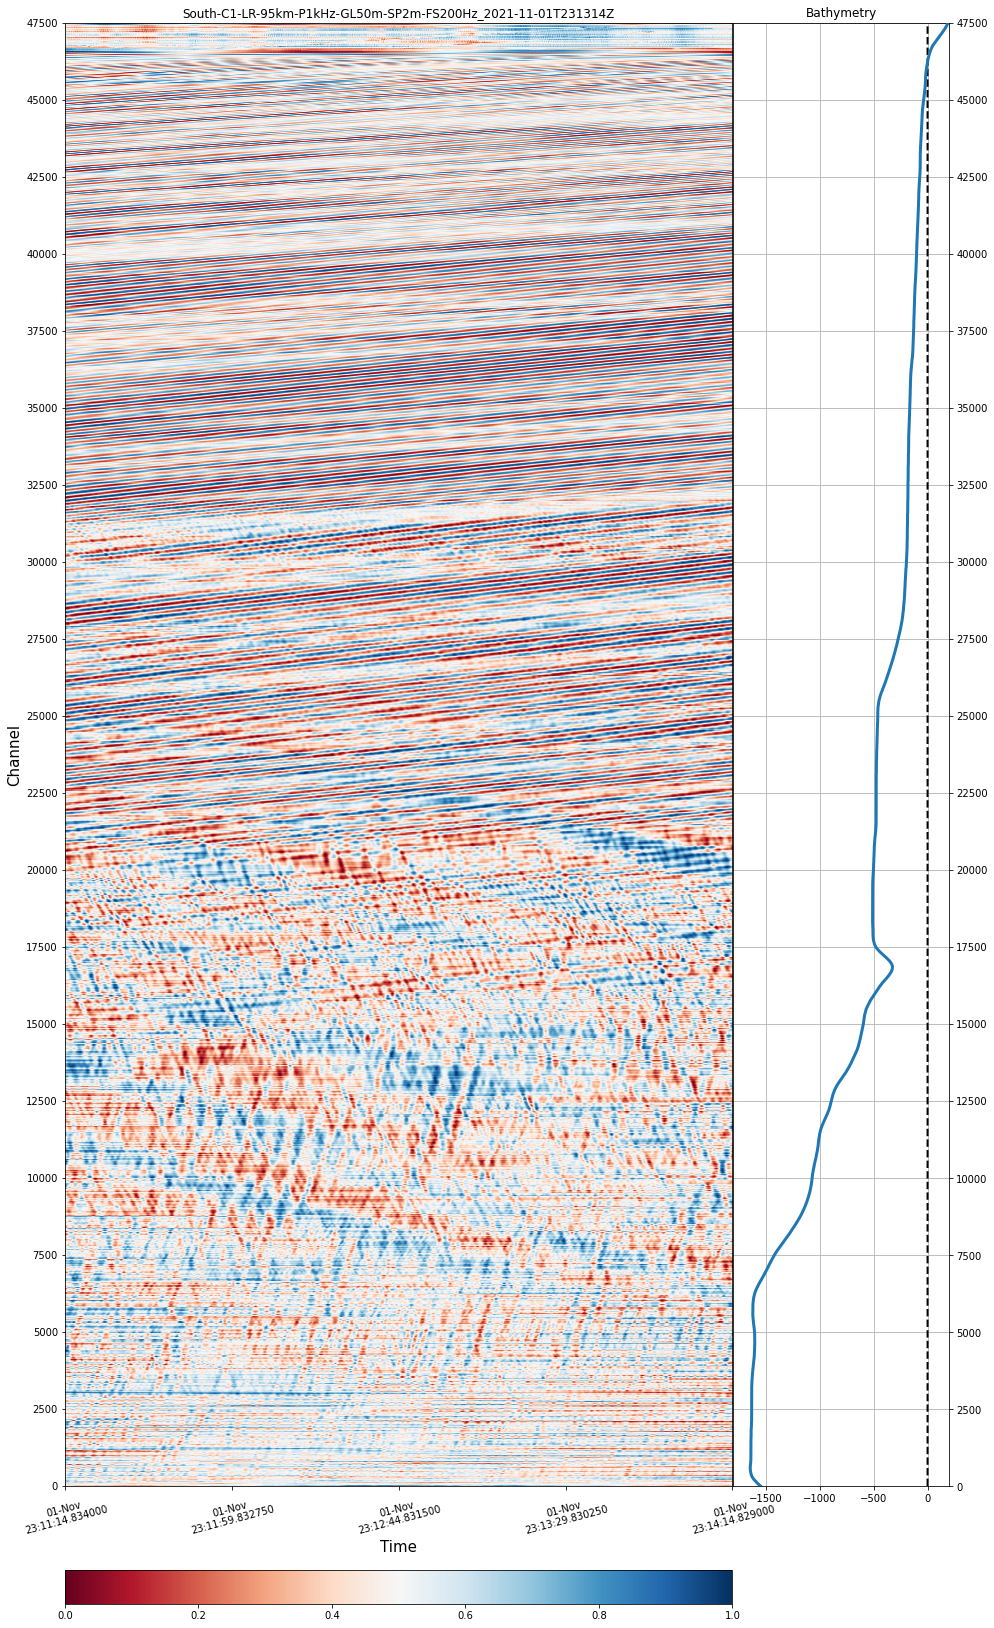

In [6]:
downsample_space=10 # At the scale of plotting, the downsampling is imperceptible
downsample_time=10 # At the scale of plotting, the downsampling is imperceptible

x_lims = list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]]))
x_lims = mdates.date2num(x_lims)
y_lims = [0, 47500]
fig, ax = plt.subplots(figsize = (10, 30))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((filt_normdata[::downsample_space,::downsample_time]),
               extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]],  
               aspect = 1/10405363, cmap = 'RdBu')
ax.xaxis_date()
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=15)

plt.xticks(np.linspace(x_lims[0], x_lims[1], 5))
plt.yticks(np.linspace(0, 47500, 20))
plt.title(file.split('.')[0])
plt.colorbar(im, ax = ax, location = 'bottom', pad = 0.04)

fig.add_axes([0.975, 0.199, 0.3, 0.6775])
plt.gca().yaxis.tick_right()
plt.plot(bathn[::-1], np.arange(47500), linewidth = 3, zorder = 90, label = 'Bathymetry')
plt.plot(np.zeros(47500), np.arange(47500), 'k--', linewidth = 2)
plt.ylim([0, 47500])
plt.grid(True)
plt.xlim([-1800, 200])
plt.yticks(np.linspace(0, 47500, 20))
plt.title("Bathymetry")
# plt.savefig("/home/niyiyu/notebooks/OOI-Figure/%s.png" % file.split('.')[0] , 
#            bbox_inches = 'tight')